In [1]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [180]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
include("./src/functions.jl")

rand_disorder (generic function with 1 method)

In [120]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.01 # planted infection rate
λi = 0.01 # inferred infection rate

d = 3 # degree (fixed for now) 
T = 4 # discrete time

γp = 0.999 # planted autoinfection probability
γi = 0.1 # inferred autoinfection probability

N = 5000; #population size

# Population dynamics for the messages

In [121]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

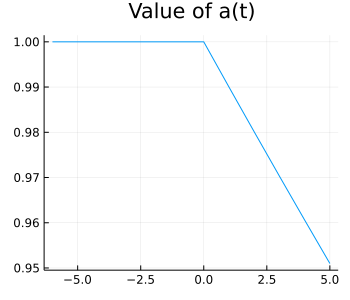

In [122]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λi)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [97]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [123]:
tot_iterations = 30000
@showprogress for iterations = 1:tot_iterations
    # Extraction of disorder: state of individual i: xi0, delays: sij and sji

    xi0,sij,sji = rand_disorder(γp,λp)

    # Initialization of ν=0
    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)

    #Beginning of calculations: we start by calculating the ν: 
    calculate_ν!(ν,μ,neighbours,xi0,T,γi,a)
    
    # Now we use the ν vector just calculated to extract the new μ.
    # We extract a population index that we call "l".
    # We overwrite the μ in postition μ[l,:,:,:,:]
    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 
    Σ = cumsum(ν,dims=3)
    update_μ!(μ,ν,Σ,l,sij,sji,T)     
end

#p1=plot(reshape(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


Once the convergence has been studied we plot the heatmaps of the messages

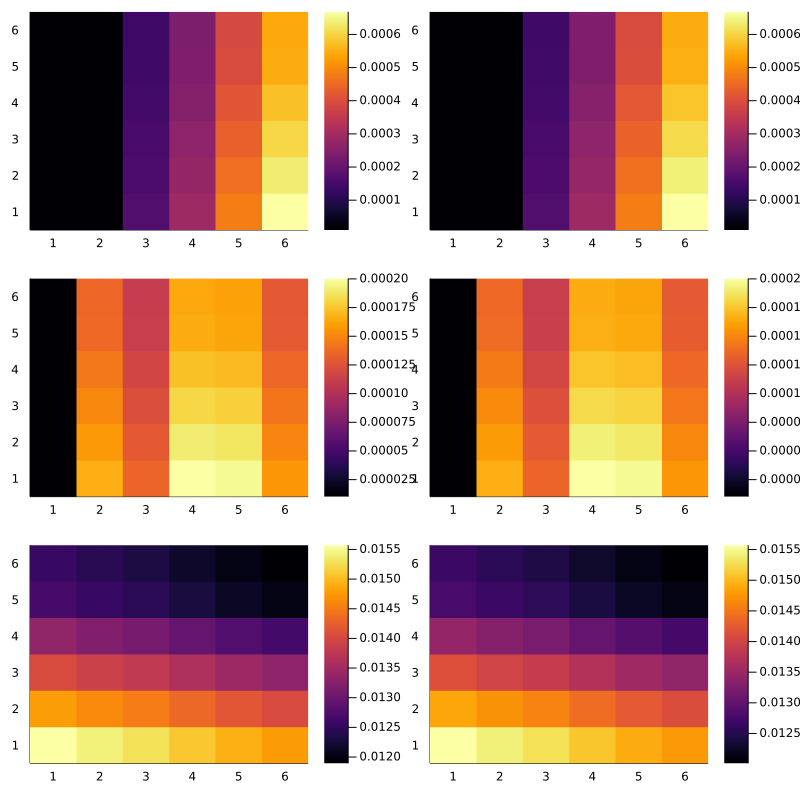

In [124]:
pl1 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,0] ./ N,T+2,T+2))
pl2 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,0] ./ N,T+2,T+2))
pl3 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,1] ./ N,T+2,T+2))
pl4 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,1] ./ N,T+2,T+2))
pl5 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,2] ./ N,T+2,T+2))
pl6 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,2] ./ N,T+2,T+2))

plot(pl1,pl2,pl3,pl4,pl5,pl6,layout = (3,2),size = (800,800))

# From messages to marginals

In [125]:
p = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2),-1,-1,-1);
marg = OffsetArrays.OffsetArray(zeros(N,T+2,T+2),0,-1,-1);
max_count = N;

In [150]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
@showprogress for l = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γp,λp) #planted disorder
    xj0 = Int(rand() < γp);
    
    ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
    ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    calculate_ν!(ν1,μ,group1,xi0,T,γi,a)
    calculate_ν!(ν2,μ,group2,xj0,T,γi,a)

    #Once the ν are calculated we have to cumulate with respect the third argument
    Σ = cumsum(ν2,dims=3)
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
end
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


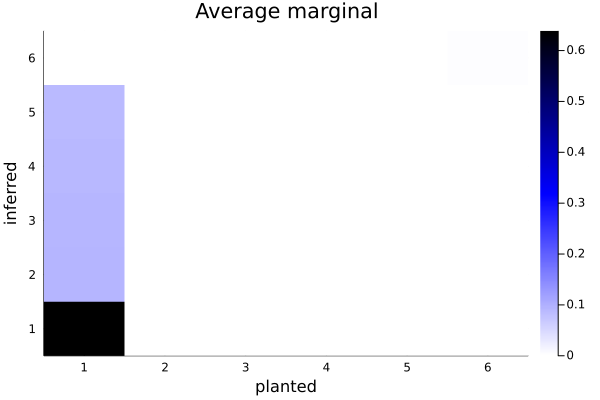

In [153]:
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

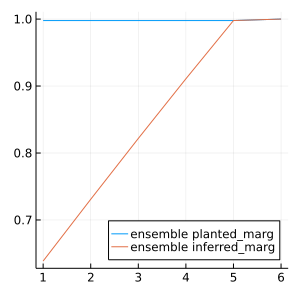

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

In [249]:
include("./src/BP.jl")

Ngraph = 10 # size of the single instance graph

G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph #the graph

# observations set in the form of 
# [(individual,state,observation time, false_rate of the test)]
# where state ∈ {0,1} respectively for S and I
# The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
# Instead we go from time 0 to time T 
# I am not completely sure that it is correct to put here T+1 and later a T+2. Maybe is more complicated. 
O = [(i,1,T+1,1e-10) for i=1:Ngraph] 

#we now run the BP algorithm for the single instance defined above
p_sib = sibyl(Ngraph, T+2, G, O, γi, λi; maxit = 40, tol = 1e-7);


sib.iterate(damp=0.0): 9/40 6.471e-09/1e-07      
sib.iterate(damp=0.5): 0/40 2.263e-09/1e-07      


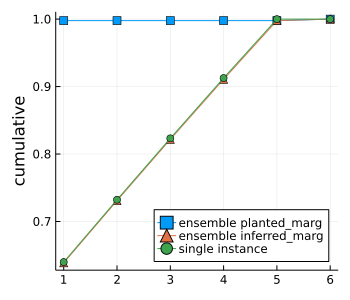

In [250]:
# we plot the marginal distribution and also the ensemble results 

p0 = plot(cumsum(sum(marg2D,dims=1)',dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2),dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)

p0 = plot!(sum(p_sib,dims=1)'/ Ngraph,marker=:circle,label="single instance")
#p1 = plot!(cumsum(sum(marg2D,dims=2),dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:topleft)
plot(p0,size=(350,300),ylabel="cumulative",)

#savefig("comparison_marg.pdf")

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

In [253]:
include("./src/sampler.jl")
include("./src/BP.jl")


sample! (generic function with 1 method)

In [ ]:
Ngraph = 10 # size of the single instance graph
x = zeros(Int,Ngraph,T)
G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph #the graph

# observations set in the form of 
# [(individual,state,observation time, false_rate of the test)]
# where state ∈ {0,1} respectively for S and I
# The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
# Instead we go from time 0 to time T 
# I am not completely sure that it is correct to put here T+1 and later a T+2. Maybe is more complicated. 
sample!(x, G, λi, γi)


#we now run the BP algorithm for the single instance defined above
p_sib = sibyl(Ngraph, T+2, G, O, γi, λi; maxit = 40, tol = 1e-7);

In [255]:
x = zeros(Int,Ngraph,T)
sample!(x, G, λi, γi)

10×4 Matrix{Int64}:
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0
 1  1  1  1
 0  0  0  0
 0  0  0  0